# Simple Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, norm
import statsmodels.api as sm
import pandas as pd

## Visualizing data centering and scaling
In this section, data centering (subtracting the mean of a variable) and scaling (dividing by some value, usually the standard deviation) are visualized. Standardizing a variable, i.e., subtracting the mean and then dividing by the standfard deviation, will make it have a zero mean and unit standard deviation. The values of this variables can be interpreted as number of standard deviations away from the mean. Ex: -1.2 is a value that is less than the mean by 1.2 standard deviations.

Note that in this visualization, the Y variable is manipulated only.

STD Y: 6.4228973108255545
Scaled STD Y: 1.0


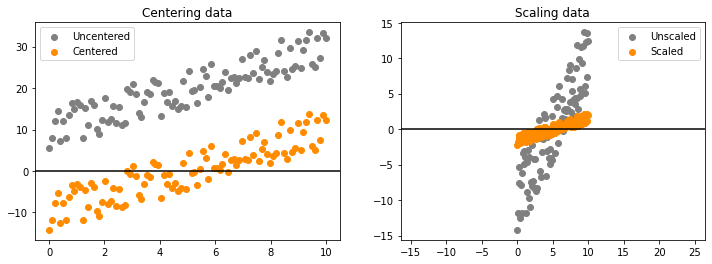

In [2]:
n = 100

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(0, 10, n)

noise = np.random.rand(n)
y = 2*x + 5 + noise*10

# Data centering
ax0 = axs[0]
ax0.scatter(x=x, y=y, color='gray', label='Uncentered')
y = y - y.mean()
ax0.scatter(x=x, y=y, color='darkorange', label='Centered')
ax0.set_title('Centering data')


# Data scaling
ax1 = axs[1]
ax1.scatter(x=x, y=y, color='gray', label='Unscaled')
plt.axis('equal')

scaled_y = y / np.std(y)
print(f'STD Y: {np.std(y)}')
print(f'Scaled STD Y: {np.std(scaled_y)}')

ax1.scatter(x=x, y=scaled_y, color='darkorange', label='Scaled')
ax1.set_title('Scaling data')

for ax in axs:
    ax.legend()
    ax.axhline(y=0, color='black')
    
plt.show()

## Fitting a Simple Linear Regression Model
In this section, Galton's father/son height data is used to fit a simple linear regression model using `statsmodels`.

In [3]:
df = pd.read_csv('data/galton_height_data.csv')

In [4]:
x = df['Father'].to_numpy().reshape(-1, 1)
y = df['Height'].to_numpy()

# Adding constant to the X variable to fit an intercept
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     73.51
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           4.35e-17
Time:                        23:18:17   Log-Likelihood:                -2384.3
No. Observations:                 898   AIC:                             4773.
Df Residuals:                     896   BIC:                             4782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.1104      3.227     12.120      0.000      32.777      45.444
x1             0.3994      0.047      8.574      0.000       0.308       0.491
==============================================================================
Omnibus:                       25.507   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.383
Skew:                           0.080   Prob(JB):                      0.00124
Kurtosis:                       2.424   Cond. No.                     1.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
# Model parameters
model.params

array([39.11038684,  0.39938127])

Plotting the fitted line

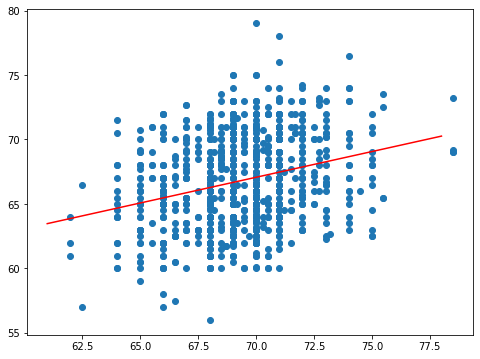

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(x=x[:, 1], y=y)

# Intercept
b = model.params[0]

# Slope
m = model.params[1]


# Plotting regression line
x_fit = np.linspace(61, 78, 100)
y_fit = m*x_fit + b

plt.plot(x_fit, y_fit, color='red')
plt.show()

Plotting the residuals

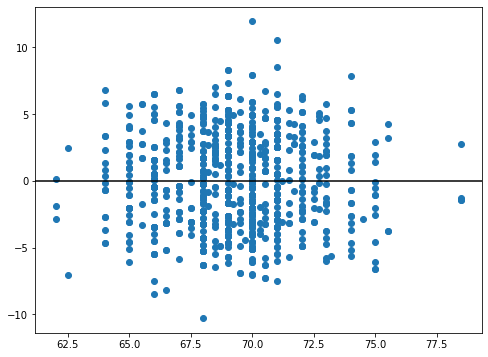

In [7]:
y_hat = model.fittedvalues
residuals = y - y_hat

plt.figure(figsize=(8, 6))
plt.scatter(x=x[:, 1], y=residuals)
plt.axhline(y=0, color='black')
plt.show()

### Testing the significance of the regression coefficients using a t-test
* See regression inference chapter pg. 50

In [8]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,39.1104,3.227,12.120,0.000,32.777,45.444
x1,0.3994,0.047,8.574,0.000,0.308,0.491


In [9]:
from scipy.stats import t

In [10]:
# Regression slope t-test
est_var = (1/(x.shape[0]-2)) * np.sum(residuals**2)
slope_st_error = np.sqrt(est_var / np.sum((x[:, 1] - x[:, 1].mean())**2))

stat = m / slope_st_error
df = x.shape[0] - 2

p_val = (1 - t.cdf(x=stat, df=df)) * 2
p_val

0.0

Computing the p-value using a permutation test by permuting the target variable and computing the correlation between the regression variable and the shuffled target variable. The ratio of iterations with a correlation equal or higher than the observed correlation.

In [20]:
# Computing the p_value by permutation
n = 10000
corr_arr = np.zeros(n)
shuffled_y = y.copy()
obs_corr = np.sqrt(model.rsquared)

for i in range(n):
    np.random.shuffle(shuffled_y)
    corr_arr[i] = np.corrcoef(x[:, 1], shuffled_y)[0, 1]
    
p_val_bootstrapp = np.mean(corr_arr >= obs_corr)
p_val_bootstrapp

0.0

Creating a confidence interval

In [21]:
# Creating a confidence interval for the slope
slope_st_error = model.bse[1]
CI = m + np.array([-1, 1]) * slope_st_error * t.ppf(0.975, df=x.shape[0]-2)
print(f'Slope: {m}')
print(f'95% Confidence Interval: {CI}')

Slope: 0.3993812658985586
95% Confidence Interval: [0.3079585  0.49080403]


## Plotting mean value (regression line) and prediction intervals
There are two types of intervals:

* Regression line interval (Also referred to as mean value interval or confidence interval), which is our confidence about the regression line we inferred from the data. If we have the real coefficients this interval will collapse to a line.

* Prediction interval, which is how confident we are about the real value of the predicted variable. In this case, even if we have the real coefficients that represent the relationship between the explanatory variable and the target variable, there is still regression variance left in the predicted value, which is variance that this variable does not explain.

The prediction interval contains both influences, our confidence in the coefficients and the variability of the target variable.

See prediction of outcomes page 53


In [22]:
df = pd.read_csv('data/galton_height_data.csv')

x = df['Father'].to_numpy()
y = df['Height'].to_numpy()

# Fitting using Scipy's linregress
fit = linregress(x, y)

In [23]:
fit

LinregressResult(slope=0.3993812658985667, intercept=39.1103868370753, rvalue=0.2753548262521483, pvalue=4.3545879582076175e-17, stderr=0.04658211556373602, intercept_stderr=3.227062585477631)

In [24]:
# Slope
m = fit.slope

# Intercept
b = fit.intercept

# Predictions
y_hat = m*x + b

# Residuals
residuals = y - y_hat

# Residual variance
n = x.shape[0]
res_var = (1/(n-2)) * np.sum(residuals**2)

# Regression line coordinates
x_coord = np.linspace(x.min(), x.max(), 100)
y_coord = y_hat = m*x_coord + b

# Regrssion line (Mean value) standard error
reg_line_st_error = np.sqrt(res_var) * np.sqrt( (1./n) + (x_coord - x.mean())**2 / np.sum((x - x.mean())**2) )
prediction_st_error = np.sqrt(res_var) * np.sqrt( 1 + (1./n) + (x_coord - x.mean())**2 / np.sum((x - x.mean())**2) )

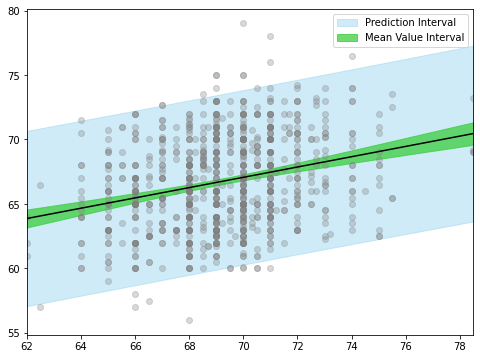

In [25]:
plt.figure(figsize=(8, 6))


# Plotting regression line
plt.plot(x_coord, y_coord, color='black')

# Plotting prediction 95% CI
lower_bound = y_coord + t.ppf(0.975, df=n-2)*prediction_st_error
upper_bound = y_coord - t.ppf(0.975, df=n-2)*prediction_st_error
plt.fill_between(x_coord, y1=lower_bound, y2=upper_bound, color='skyblue', alpha=.4, label='Prediction Interval')

# Plotting mean value 95% CI
lower_bound = y_coord + 1.96*reg_line_st_error
upper_bound = y_coord - 1.96*reg_line_st_error
plt.fill_between(x_coord, y1=lower_bound, y2=upper_bound, color='limegreen', alpha=0.7, label='Mean Value Interval')

# Plotting data points
plt.scatter(x=x, y=y, color='gray', alpha=0.3)

plt.xlim(x.min(), x.max())
plt.legend()
plt.show()

Plotting using Seaborn

In [26]:
import seaborn as sns

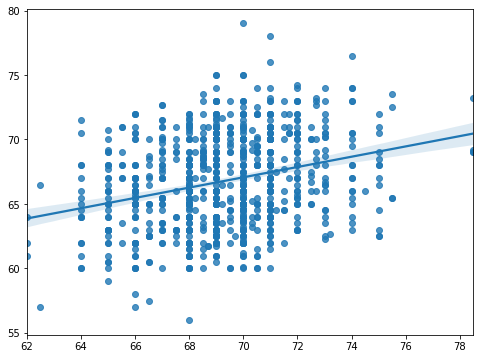

In [27]:
plt.figure(figsize=(8, 6))

sns.regplot(x=x, y=y, x_ci='sd')

plt.show()

#### Creating mean value confidence interval using bootstrapp
* See [this](https://www.youtube.com/watch?v=c3gD_PwsCGM) Youtube video
* See [this](https://stats.stackexchange.com/questions/226565/bootstrap-prediction-interval) StackExchange answer

In [28]:
n_iter = 10000
n = x.shape[0]
xy = np.array([x, y]).reshape(-1, 2)

# Regression line coordinates
x_coord = np.linspace(x.min(), x.max(), 100)
y_coord = m*x_coord + b
y_hat = m*x + b

# Residuals
residuals = y - y_hat

# Array to hold the bootstrapped mean value predictions
mean_value_bootstrapp = np.zeros((n_iter, x_coord.shape[0]))

# Array to hold the bootstrapped predictions (With residual variance incorporated)
prediction_bootstrapp = np.zeros((n_iter, x_coord.shape[0]))

# List to hold all the bootstrapped fits
fit_list = []

for i in range(n_iter):
    
    # Sampling data with replacement
    bootstrapp_indices = np.random.choice(n, size=n, replace=True)
    
    # Fitting LR to the sampled data
    bootstrapp_fit = linregress(x[bootstrapp_indices], y[bootstrapp_indices])
    fit_list.append(bootstrapp_fit)
    
    # Mean value prediction using this iteration's slope and intercept
    y_iter = bootstrapp_fit.slope * x_coord + bootstrapp_fit.intercept
    mean_value_bootstrapp[i] = y_iter
    
    # Sampling residuals
    res_sample = np.random.choice(residuals, size=x_coord.shape[0], replace=True)
    
    # The assumed real value of the target variable at the studied points
    # y_true = y_hat + error
    y_true = y_iter + res_sample
    prediction_bootstrapp[i] = y_true

In [29]:
# Standard error of the "predicted true value" and mean value 
prediction_std = prediction_bootstrapp.std(axis=0)
mean_value_std = mean_value_bootstrapp.std(axis=0)

The following plot shows the change in the standard deviation of the mean value (regression line prediction). It can be seen that this value is at its minimum at the mean of the X variable and increases as we move away. This is because we are most sure about our prediction next to the mean, and our confidence decreases as we move away. (See the term in the nominator of the regression line standard error function). This can also be explained by visualizing all the sampled regression lines plotted. As we move away from the mean, the effect of the slope is magnified, whereas at the mean value we are observing the uncertainty in the intercept only.

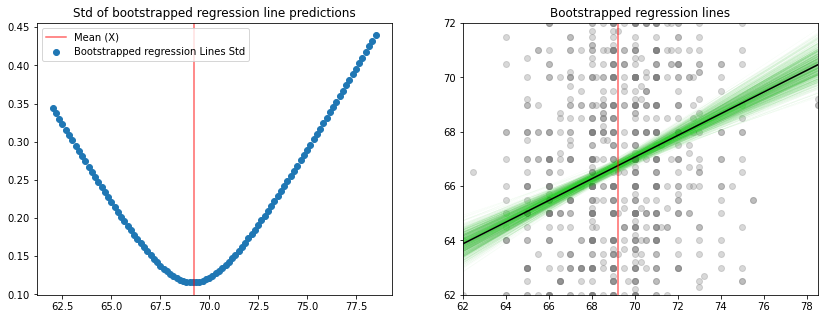

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ax0 = axs[0]
ax0.scatter(x=x_coord, y=mean_value_std, label='Bootstrapped regression Lines Std')
ax0.axvline(x=x.mean(), color='red', alpha=0.6, label='Mean (X)')
ax0.set_title('Std of bootstrapped regression line predictions')
ax0.legend()

ax1 = axs[1]
for iter_fit in fit_list[:1000]:
    y_iter = iter_fit.slope * x_coord + iter_fit.intercept
    ax1.plot(x_coord, y_iter, color='limegreen', alpha=0.2, lw=0.1)
    
ax1.plot(x_coord, y_coord, color='black')
ax1.scatter(x=x, y=y, color='gray', alpha=0.3)
ax1.axvline(x=x.mean(), color='red', alpha=0.6)
ax1.set_ylim(62, 72)
ax1.set_xlim(x.min(), x.max())
ax1.set_title('Bootstrapped regression lines')

plt.show()

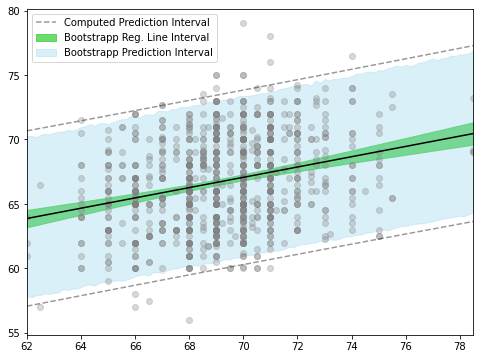

In [31]:
plt.figure(figsize=(8, 6))

prediction_ci_lower_bound = np.quantile(prediction_bootstrapp, 0.025, axis=0)
prediction_ci_upper_bound = np.quantile(prediction_bootstrapp, 0.975, axis=0)

regline_ci_lower_bound = np.quantile(mean_value_bootstrapp, 0.025, axis=0)
regline_ci_upper_bound = np.quantile(mean_value_bootstrapp, 0.975, axis=0)

# Plotting regression line
plt.plot(x_coord, y_coord, color='black')

# Plotting bootstrapped regression line interval
plt.fill_between(x=x_coord, y1=regline_ci_lower_bound, y2=regline_ci_upper_bound,
                 color='limegreen', alpha=0.7, label='Bootstrapp Reg. Line Interval')

# Plotting bootstrapped prediction interval
plt.fill_between(x=x_coord, y1=prediction_ci_lower_bound, y2=prediction_ci_upper_bound,
                 color='skyblue', alpha=0.3, label='Bootstrapp Prediction Interval')

# Plotting data points
plt.scatter(x=x, y=y, color='gray', alpha=0.3)

# PLotting computed confidence intervals
# Prediction 95% CI
lower_bound = y_coord + t.ppf(0.975, df=n-2)*prediction_st_error
upper_bound = y_coord - t.ppf(0.975, df=n-2)*prediction_st_error
plt.plot(x_coord, lower_bound, color='black', alpha=.4, linestyle='--', label='Computed Prediction Interval')
plt.plot(x_coord, upper_bound, color='black', alpha=.4, linestyle='--')

plt.xlim(x.min(), x.max())
plt.legend()
plt.show()

**Question:** Why is the computed interval wider than the bootstrapped interval?